In [1]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
image = preprocess(Image.open("domainbed/data/PACS/art_painting/elephant/pic_006.jpg")).unsqueeze(0).to(device)
domain_text = clip.tokenize(["a art painting image", "a cartoon image", "a photography", "a sketch"]).to(device)
class_text = clip.tokenize(["an image of dog", "an image of elephant", "an image of giraffe", "an image of guitar", "an image of horse", "an image of house", "an image of person"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    domain_text_features = model.encode_text(domain_text)
    class_text_features = model.encode_text(class_text)
    
    logits_per_image, logits_per_text = model(image, domain_text)
    domain_probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    
    logits_per_image, logits_per_text = model(image, class_text)
    cls_probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("domain_probs probs:", domain_probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
print("cls_probs probs:", cls_probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

/home/william/anaconda3/envs/pytorch1.9/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


domain_probs probs: [[9.980e-01 7.787e-04 6.976e-04 4.575e-04]]
cls_probs probs: [[1.9193e-05 9.9951e-01 3.6263e-04 1.0729e-06 1.1057e-04 7.8678e-06
  2.8372e-05]]


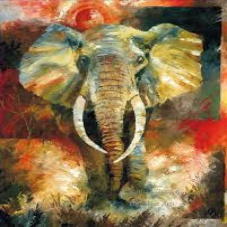

In [75]:
Image.open("domainbed/data/PACS/art_painting/elephant/pic_006.jpg").show()

In [76]:
class_text = clip.tokenize(["an image of elephant"]).to(device)
domain_text = clip.tokenize(["a cartoon image"]).to(device)
print(class_text.shape)
image = preprocess(Image.open("domainbed/data/PACS/art_painting/elephant/pic_006.jpg")).unsqueeze(0).to(device)
print(image.shape)

torch.Size([1, 77])
torch.Size([1, 3, 224, 224])


In [77]:
import math
from torch import nn
from torch.nn import functional as F
class CascadeGaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing separately for each channel (depthwise convolution).

    Arguments:
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.

    """
    def __init__(self, kernel_size, sigma):
        super().__init__()

        if isinstance(kernel_size, int):
            kernel_size = [kernel_size, kernel_size]

        cascade_coefficients = [0.5, 1.0, 2.0]  # std multipliers, hardcoded to use 3 different Gaussian kernels
        sigmas = [[coeff * sigma, coeff * sigma] for coeff in cascade_coefficients]  # isotropic Gaussian

        self.pad = int(kernel_size[0] / 2)  # assure we have the same spatial resolution

        # The gaussian kernel is the product of the gaussian function of each dimension.
        kernels = []
        meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])
        for sigma in sigmas:
            kernel = torch.ones_like(meshgrids[0])
            for size_1d, std_1d, grid in zip(kernel_size, sigma, meshgrids):
                mean = (size_1d - 1) / 2
                kernel *= 1 / (std_1d * math.sqrt(2 * math.pi)) * torch.exp(-((grid - mean) / std_1d) ** 2 / 2)
            kernels.append(kernel)

        gaussian_kernels = []
        for kernel in kernels:
            # Normalize - make sure sum of values in gaussian kernel equals 1.
            kernel = kernel / torch.sum(kernel)
            # Reshape to depthwise convolutional weight
            kernel = kernel.view(1, 1, *kernel.shape)
            kernel = kernel.repeat(3, 1, 1, 1)
            kernel = kernel.to(device)

            gaussian_kernels.append(kernel)

        self.weight1 = gaussian_kernels[0]
        self.weight2 = gaussian_kernels[1]
        self.weight3 = gaussian_kernels[2]
        self.conv = F.conv2d

    def forward(self, input):
        input = F.pad(input, [self.pad, self.pad, self.pad, self.pad], mode='reflect')

        # Apply Gaussian kernels depthwise over the input (hence groups equals the number of input channels)
        # shape = (1, 3, H, W) -> (1, 3, H, W)
        num_in_channels = input.shape[1]
        grad1 = self.conv(input, weight=self.weight1, groups=num_in_channels)
        grad2 = self.conv(input, weight=self.weight2, groups=num_in_channels)
        grad3 = self.conv(input, weight=self.weight3, groups=num_in_channels)

        return (grad1 + grad2 + grad3) / 3

In [78]:
import numpy as np
IMAGENET_MEAN_1 = np.array([0.48145466, 0.4578275, 0.40821073], dtype=np.float32)
IMAGENET_STD_1 = np.array([0.26862954, 0.26130258, 0.27577711], dtype=np.float32)
LOWER_IMAGE_BOUND = torch.tensor((-IMAGENET_MEAN_1 / IMAGENET_STD_1).reshape(1, -1, 1, 1)).to(device)
UPPER_IMAGE_BOUND = torch.tensor(((1 - IMAGENET_MEAN_1) / IMAGENET_STD_1).reshape(1, -1, 1, 1)).to(device)

model.eval()
def gradient_ascent(lr, model, input_tensor, cur_iteration, total_iteration, smoothing_coefficient):
    # Step 0: Feed forward pass
    image_features = model.encode_image(input_tensor)
    domain_text_features = model.encode_text(domain_text)
    class_text_features = model.encode_text(class_text)

    loss =  + torch.log((image_features @ class_text_features.T).squeeze()) + torch.log((image_features @ domain_text_features.T).squeeze())

    loss.backward()

    # Step 3: Process image gradients (smoothing + normalization, more an art then a science)
    grad = input_tensor.grad.data

    # Applies 3 Gaussian kernels and thus "blurs" or smoothens the gradients and gives visually more pleasing results
    # We'll see the details of this one in the next cell and that's all, you now understand DeepDream!
    sigma = ((cur_iteration + 1) / total_iteration) * 2.0 + smoothing_coefficient
    smooth_grad = CascadeGaussianSmoothing(kernel_size=9, sigma=sigma)(grad)  # "magic number" 9 just works well

    # Normalize the gradients (make them have mean = 0 and std = 1)
    # I didn't notice any big difference normalizing the mean as well - feel free to experiment
    g_std = torch.std(smooth_grad)
    g_mean = torch.mean(smooth_grad)
    smooth_grad = smooth_grad - g_mean
    smooth_grad = smooth_grad / g_std

    # Step 4: Update image using the calculated gradients (gradient ascent step)
    input_tensor.data += lr * smooth_grad

    # Step 5: Clear gradients and clamp the data (otherwise values would explode to +- "infinity")
    input_tensor.grad.data.zero_()
    input_tensor.data = torch.max(torch.min(input_tensor, UPPER_IMAGE_BOUND), LOWER_IMAGE_BOUND)

In [79]:
def pytorch_output_adapter(tensor):
    # Push to CPU, detach from the computational graph, convert from (1, 3, H, W) tensor into (H, W, 3) numpy image
    return np.moveaxis(tensor.to('cpu').detach().numpy()[0], 0, 2)

def post_process_numpy_img(img):
    assert isinstance(img, np.ndarray), f'Expected numpy image got {type(img)}'

    if img.shape[0] == 3:  # if channel-first format move to channel-last (CHW -> HWC)
        img = np.moveaxis(img, 0, 2)

    mean = IMAGENET_MEAN_1.reshape(1, 1, -1)
    std = IMAGENET_STD_1.reshape(1, 1, -1)
    img = (img * std) + mean  # de-normalize
    img = np.clip(img, 0., 1.)  # make sure it's in the [0, 1] range

    return img

In [82]:
from matplotlib import pyplot as plt
import tqdm

t_total = 50
lr = 0.1
image.requires_grad = True
smoothing_coefficient = 0.5
for iteration in tqdm.tqdm(range(t_total)):
    gradient_ascent(lr, model, image, iteration, t_total, smoothing_coefficient)



100%|██████████| 50/50 [00:04<00:00, 11.10it/s]


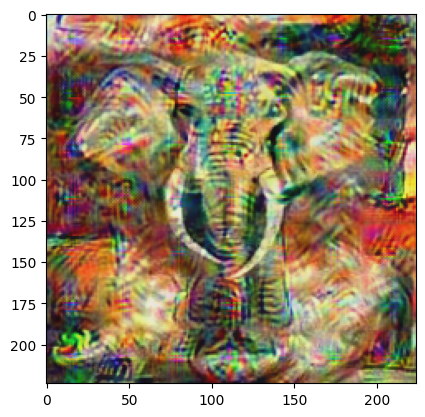

In [83]:
def denormalize(images, type="imagenet"):
    # images [b, 3, H, W]
    mean = torch.tensor([0.485, 0.456, 0.406], device=images.device).view(1, 3, 1, 1).type_as(images)
    std = torch.tensor([0.229, 0.224, 0.225], device=images.device).view(1, 3, 1, 1).type_as(images)
    return std * images + mean

plt.imshow(denormalize(image.to('cpu').detach()).squeeze().permute(1, 2, 0))